In [1]:
### FUNCTION DEFINITION BLOCK ###

# Read the modeling data from the CSV file
def get_Strategic_Subject_List_Data():
    raw_data = pd.read_csv("Strategic_Subject_List.csv", low_memory = False)
    #Replace spaces in column names by underscore
    raw_data.columns = [x.strip().replace(' ', '_') for x in raw_data.columns]
    #Replace the blank values with NAN 
    raw_data.replace(r'^\s+$', np.nan, regex=True, inplace = True)
    return(raw_data)

# Used only age as the predictor
def feature_selection(raw_data):
    final_features = raw_data[['SSL_SCORE','AGE_TO']]
    #final_features = raw_data[['SSL_SCORE','AGE_GROUP']]
    return(final_features)

# Segregating the Categorical and Numerical Variables
def defining_categorical(final_features):
    
    categorical = final_features.select_dtypes(include=['object'])
    numeric = final_features.select_dtypes(exclude=['object'])

    #Defining the Dummy variables for the categorical variables 
    for name, values in categorical.items():
        dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
        numeric = pd.concat([numeric, dummies], axis=1)

    return(numeric)

#Imputing the missing values 
def impute_missing_values(numeric):
    for name in numeric:
        if pd.isnull(numeric[name]).sum() > 0:
            numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
            median = numeric[name].median()
            numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
    return(numeric)

In [2]:
# Importing the required libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from sklearn import preprocessing


#Adjusting the display options of Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#Importing the python matplot library for exploratory data analysis
import matplotlib.pyplot as plt
import pandas as pd

# Import the raw data from the csv file
raw_data = get_Strategic_Subject_List_Data()

# Selecting final features for the model
final_features = feature_selection(raw_data)

In [3]:
### Data Processing Block ###

# Converting the required variables to categorical 
numeric = defining_categorical(final_features)
# Imputing missing values
numeric = impute_missing_values(numeric)


In [4]:
# Defining the target variable and independent variables

y = numeric['SSL_SCORE']
X = numeric.drop(['SSL_SCORE'], axis = 1)

# Creating a Holdout for Testing of 20%
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [5]:
from sklearn.ensemble import ExtraTreesRegressor
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
feature_names = X.columns
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.437023)
2. feature 6 (0.314970)
3. feature 1 (0.176481)
4. feature 2 (0.056263)
5. feature 3 (0.013615)
6. feature 5 (0.001622)
7. feature 7 (0.000014)
8. feature 4 (0.000012)


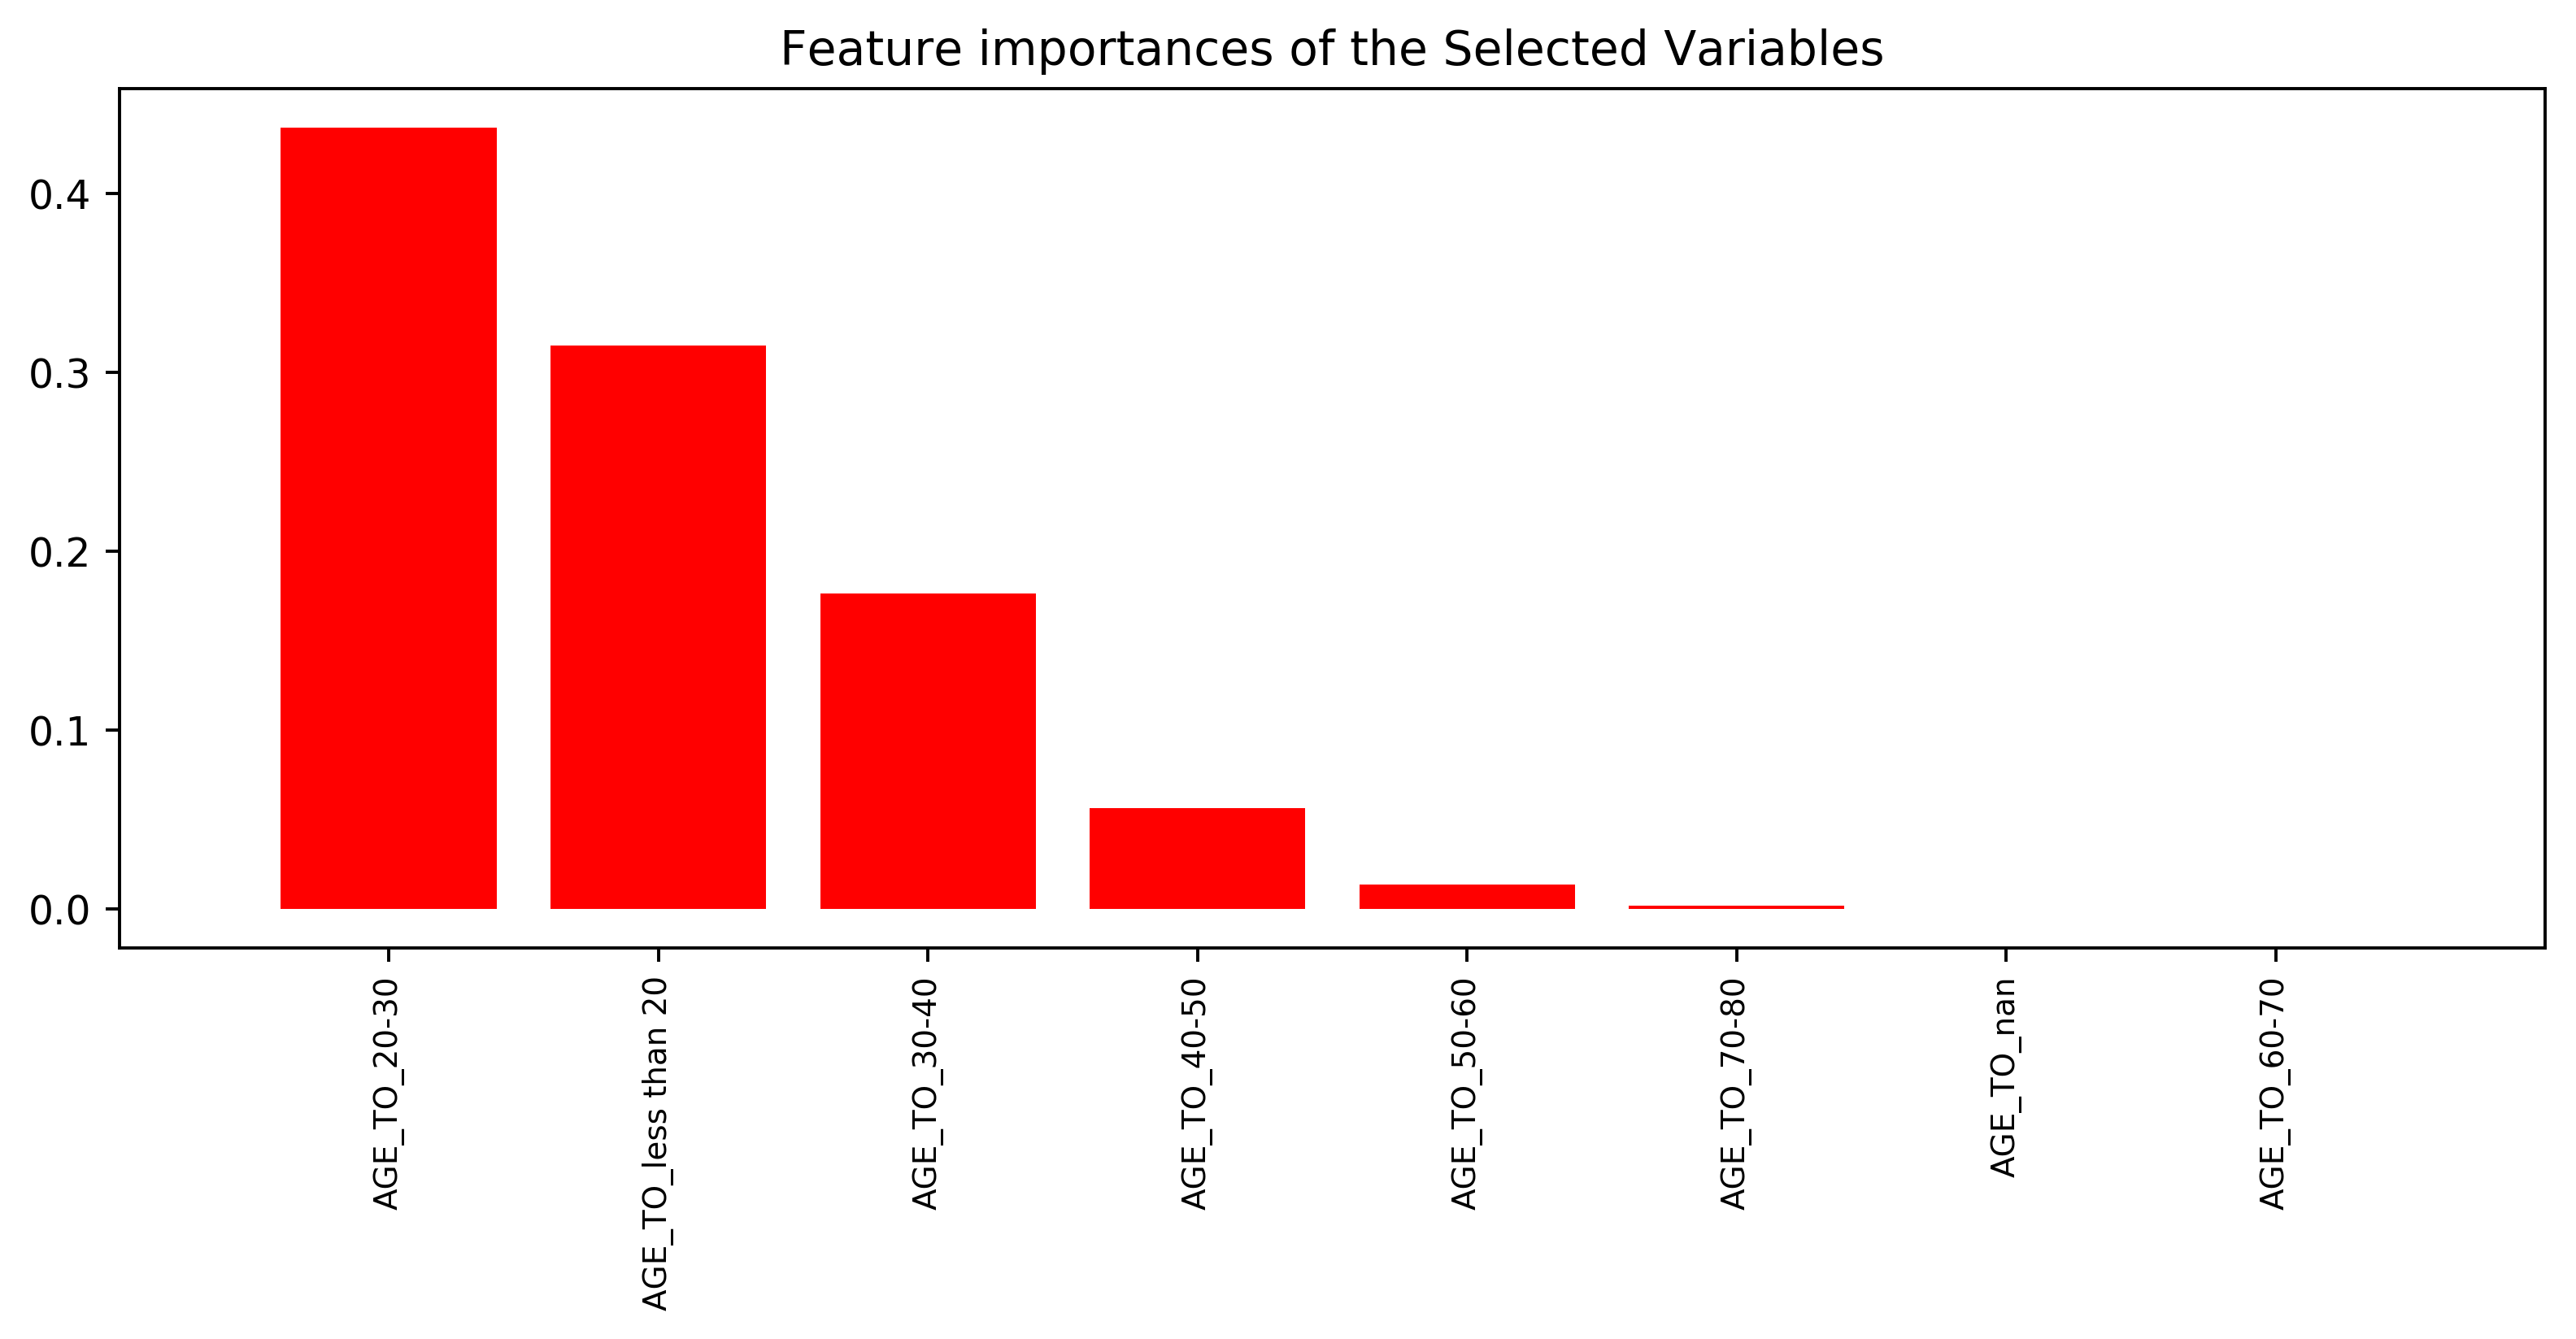

In [6]:
# Plot the feature importances of the forest
plt.figure(figsize=(11, 4), dpi=350)
plt.title("Feature importances of the Selected Variables")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices],rotation=90,size=8)
plt.xlim([-1, X.shape[1]])
plt.show()

In [8]:
# GLM Ridge model using sk-learn ##
from sklearn import linear_model
reg = linear_model.Ridge()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', reg) ])
# Parameter tuning
alpha=[0.005]

from sklearn.model_selection import GridSearchCV
optimized_reg = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__alpha = alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_reg.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__alpha': [0.005]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [15]:
# The cofficients value
optimized_reg.best_estimator_.steps[-1][1].coef_

array([ 17.3830914 ,  -3.38312533, -18.61494029, -26.43912736,
       -18.73736641,  -9.12217216,  26.98196793,  -2.95050633])

In [16]:
# The Intercept Value
optimized_reg.best_estimator_.steps[-1][1].intercept_

279.96558048829428

In [17]:
## Evaluating GLM - Ridge Regression on Holdout - Test Data, using mean_squared_error metrics ##
from sklearn.metrics import mean_squared_error
y_pred = optimized_reg.predict(X_test)
print("The Mean Squared Error Using GLM - Ridge is : ",mean_squared_error(y_test, y_pred))

The Mean Squared Error Using GLM - Ridge is :  397.501617678


In [18]:
## Evaluating GLM - Ridge Regression on Holdout - Test Data, using R2 Metrics ##
from sklearn.metrics import r2_score
y_pred = optimized_reg.predict(X_test)
print("The R2 Using GLM - Ridge is :",r2_score(y_test, y_pred))

The R2 Using GLM - Ridge is : 0.88258759593
